In [47]:
import os
import cv2
import numpy as np      
from tqdm import tqdm 

In [48]:
REBUILD_DATA=False
#initially it was true, but we don't want to rebuild data again and again
#so once we made training data then we set rebuild_data to false.

In [49]:
class DogsVsCats():
    IMG_SIZE=50
    CATS="kagglecatsanddogs_5340/PetImages/Cat/"
    DOGS="kagglecatsanddogs_5340/PetImages/Dog/"
    LABELS={CATS:0, DOGS:1}
    training_data=[]
    catcount=0
    dogcount=0
  
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path=os.path.join(label, f)
                    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img=cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    
                    if label==self.CATS:
                        self.catcount+=1
                    elif label==self.DOGS:
                        self.dogcount+=1
                except Exception as e:
                    pass
                    # print(str(e))
    
        np.random.shuffle(self.training_data)
        images = np.array([i[0] for i in self.training_data]).reshape(-1, self.IMG_SIZE, self.IMG_SIZE, 1)
        labels = np.array([i[1] for i in self.training_data])
        print("CATS:", self.catcount)
        print("DOGS:", self.dogcount)
        
        np.save("training_data_images.npy", images)
        np.save("training_data_labels.npy", labels)
    
if REBUILD_DATA:
    dogsvscats=DogsVsCats()
    dogsvscats.make_training_data()


In [50]:
# Load the images and labels arrays from the saved .npy files
train_images = np.load("training_data_images.npy")
train_labels = np.load("training_data_labels.npy")

# Now you can work with the loaded data as NumPy arrays
print("Images shape:", train_images.shape)
print("Labels shape:", train_labels.shape)


Images shape: (24946, 50, 50, 1)
Labels shape: (24946, 2)


*1 is for gray scale*,
*2 is for hot encoded labels*,
*24946 is number of images*

In [51]:
train_images[0]

array([[[175],
        [172],
        [179],
        ...,
        [136],
        [137],
        [139]],

       [[173],
        [175],
        [175],
        ...,
        [136],
        [137],
        [137]],

       [[173],
        [174],
        [175],
        ...,
        [136],
        [137],
        [137]],

       ...,

       [[133],
        [132],
        [133],
        ...,
        [ 37],
        [ 66],
        [ 93]],

       [[134],
        [134],
        [135],
        ...,
        [ 79],
        [ 79],
        [ 98]],

       [[136],
        [138],
        [131],
        ...,
        [105],
        [102],
        [ 77]]], dtype=uint8)

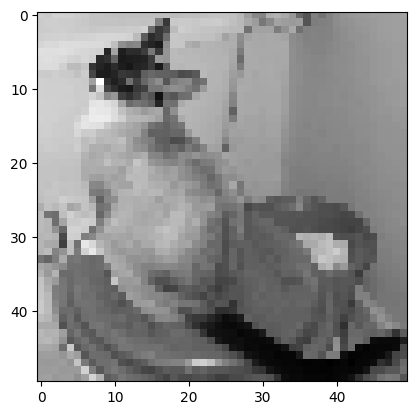

In [52]:
#above is gray scale values between 0 to 1

import matplotlib.pyplot as plt    
plt.imshow(train_images[0], cmap="gray")
plt.show()

In [53]:
train_labels[0]

array([1., 0.])

array([0., 1.]) means dog and
array([1., 0.]) means cat

In [54]:
#running after setting rebuild_data=false
train_images = np.load("training_data_images.npy")
train_labels = np.load("training_data_labels.npy")

print(len(train_images))
print(len(train_labels))

24946
24946


In [63]:
import torch
import torch.nn as nn     
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,32,5)
    self.conv2=nn.Conv2d(32,64,5)
    self.conv3=nn.Conv2d(64,128,5)
    
    x=torch.randn(50,50).view(-1,1,50,50)
    self._to_linear=None
    self.convs(x)    
    
    self.fc1=nn.Linear(self._to_linear,512)
    self.fc2=nn.Linear(512,2)
  
  def convs(self,x):
    x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
    x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
    x=F.max_pool2d(F.relu(self.conv3(x)),(2,2))
    #print(x[0].shape)
    if self._to_linear is None:
      self._to_linear=x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x
  
  def forward(self,x):
    x=self.convs(x)
    x=x.view(-1,self._to_linear)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    return F.softmax(x,dim=1)
    
net=Net()

In [64]:
import torch.optim as optim   

optimizer=optim.Adam(net.parameters(),lr=1e-3)
loss_function=nn.MSELoss()

X=torch.Tensor([i for i in train_images]).view(-1,50,50)
X=X/255.0

y=torch.Tensor([i for i in train_labels])

val_pct=0.1 #test against 10% of dataset

val_size=int(len(X)*val_pct)
print(val_size)


2494


In [65]:
train_X=X[:-val_size]
train_y=y[:-val_size]

test_X=X[-val_size:]
test_y=y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [99]:
BATCH_SIZE=100
EPOCHS=1
loss_values = []
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i + BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item())
  

100%|██████████| 225/225 [00:26<00:00,  8.47it/s]


In [100]:
print(f'Final Training Loss: {loss_values[-1]}')

Final Training Loss: 0.025855304673314095


In [88]:
def test_model(model, X, y, name="Test Set"):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(X))):
            real_class = torch.argmax(y[i])
            net_out = model(X[i].view(-1, 1, 50, 50))[0]
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    accuracy = round(correct / total, 3)
    print(accuracy)
    return accuracy

train_accuracy = test_model(net, train_X, train_y, name="Training Set")

100%|██████████| 22452/22452 [00:48<00:00, 465.69it/s]

0.913


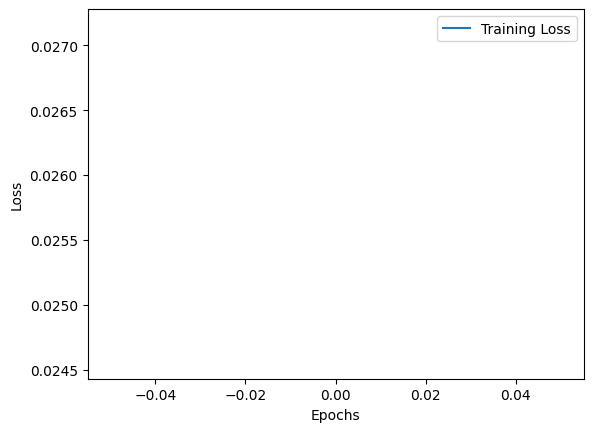

In [101]:
def plot_loss(loss_values):
    plt.plot(range(len(loss_values)), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(loss_values)

No curve because of single epoch

**PREDICTING CAT OR DOG**

In [105]:
# Function to preprocess a single external image
def preprocess_external_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to 50x50
    img = cv2.resize(img, (50, 50))

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Normalize the pixel values to be between 0 and 1
    img_array = img_array / 255.0

    # Convert the NumPy array to a PyTorch tensor
    img_tensor = torch.Tensor(img_array).view(-1, 50, 50)

    return img_tensor

# Example usage:
image_path = r"C:\Users\shory\Desktop\ML\dog1.jpg"
external_image_tensor = preprocess_external_image(image_path)

# Make a prediction using the trained model
with torch.no_grad():
    prediction = net(external_image_tensor.view(-1, 1, 50, 50))[0]
    predicted_class = torch.argmax(prediction).item()

# Display the prediction
if predicted_class == 0:
    print("Model Predicted: Cat")
else:
    print("Model Predicted: Dog")


Model Predicted: Dog
